We will implement RNN, LSTM and GRU for sentiment analysis of the movie reviews. We will use IMDB 50000 dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/Deep Learning

/content/drive/MyDrive/Deep Learning


# Step 1: Load the IMDb dataset

import libraries

In [ ]:
# data manipulation
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# text processing
import re
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
stopwords = set(stopwords.words('english'))   #Creates a set of stop words from the NLTK stopwords corpus

# pytorch
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader

# sklearn
from sklearn.metrics import classification_report, confusion_matrix

# utils
import os
from tqdm import tqdm
tqdm.pandas()  #This function enables progress bars for Pandas DataFrames.
#This can be useful for tracking the progress of operations such as filtering, sorting, and aggregating large DataFrames.
from collections import Counter   #Data structure that counts the occurrences of elements in a sequence.
#This can be useful for tasks such as finding the most common words in a text corpus

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Deep Learning/IMDB Dataset.csv")

In [ ]:
data

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [ ]:
data.loc[0].review

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [ ]:
# Define a function to transform a sentiment label into a binary value
def transform_label(label):
    # Check if the label is 'positive', and if so, return 1; otherwise, return 0
    return 1 if label == 'positive' else 0

# Apply the 'transform_label' function to each 'sentiment' value in the 'data' DataFrame
# and store the results in a new 'label' column in the same DataFrame.
data['label'] = data['sentiment'].progress_apply(transform_label)
#The progress_apply() function is a modified version of the apply() function that adds a progress bar to the operation.

# Display the first few rows of the DataFrame to show the new 'label' column
data.head()


100%|██████████| 50000/50000 [00:00<00:00, 929407.39it/s]


,review,sentiment,label
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1


In [ ]:
data.sentiment.value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

In [ ]:
# Add a new column 'token_length' to the 'data' DataFrame

# Using the 'progress_apply' method, apply a lambda function to each row in the 'review' column.
# The lambda function calculates the number of tokens in each 'review' by splitting it using spaces and computing the length.
data['token_length'] = data.review.progress_apply(lambda x: len(x.split()))

100%|██████████| 50000/50000 [00:00<00:00, 72793.16it/s]


In [ ]:
data

,review,sentiment,label,token_length
0,One of the other reviewers has mentioned that ...,positive,1,307
1,A wonderful little production. <br /><br />The...,positive,1,162
2,I thought this was a wonderful way to spend ti...,positive,1,166
3,Basically there's a family where a little boy ...,negative,0,138
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1,230
...,...,...,...,...
49995,I thought this movie did a down right good job...,positive,1,194
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,0,112
49997,I am a Catholic taught in parochial elementary...,negative,0,230
49998,I'm going to have to disagree with the previou...,negative,0,212


Create a new DataFrame 'data_pos' by filtering 'data' for rows where the 'label' is equal to 1 (positive sentiment).

In [ ]:
# Using the 'describe' method on the 'token_length' column of the 'data_pos' DataFrame,
# generate descriptive statistics for the token length of positive sentiment reviews.
data_pos = data[data['label'] == 1]
data_pos['token_length'].describe()


count    25000.000000
mean       232.849320
std        177.497046
min         10.000000
25%        125.000000
50%        172.000000
75%        284.000000
max       2470.000000
Name: token_length, dtype: float64

For positive reviews, we have maximum token 2470 and minimum token 10. While the average token is 232.

Create a new DataFrame 'data_neg' by filtering 'data' for rows where the 'label' is equal to 0 (negative sentiment).

In [ ]:
# Using the 'describe' method on the 'token_length' column of the 'data_neg' DataFrame,
# generate descriptive statistics for the token length of negative sentiment reviews.
data_neg = data[data['label'] == 0]
data_neg['token_length'].describe()


count    25000.000000
mean       229.464560
std        164.947795
min          4.000000
25%        128.000000
50%        174.000000
75%        278.000000
max       1522.000000
Name: token_length, dtype: float64

And for negative reviews, we have maximum and minimum token respectively 1522 and 4. While the average token is 229.

<Figure size 500x800 with 0 Axes>

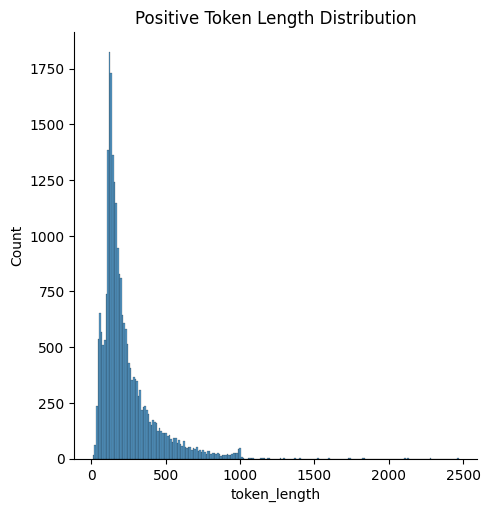

In [ ]:
plt.figure(figsize=(5, 8))
sns.displot(data_pos, x='token_length')
plt.title('Positive Token Length Distribution')
plt.show()

<Figure size 500x800 with 0 Axes>

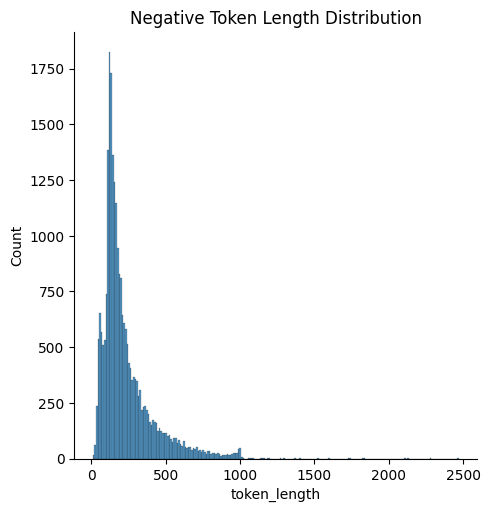

In [ ]:
plt.figure(figsize=(5, 8))
sns.displot(data_pos, x='token_length')
plt.title('Negative Token Length Distribution')
plt.show()

Display the review with the shortest token length in both positive and negative sentiment categories


In [ ]:
# Print 'Positive' to indicate that the following output is related to positive sentiment reviews.
print('Positive')

# Using the 'data_pos' DataFrame, find the row(s) where 'token_length' is equal to the minimum token length,
# and then extract and print the 'review' text for the review(s) with the shortest length.
print(data_pos[data_pos['token_length'] == data_pos['token_length'].min()]['review'].item())

# Print an empty line for separation.
print()

# Print 'Negative' to indicate that the following output is related to negative sentiment reviews.
print('Negative')

# Using the 'data_neg' DataFrame, find the row(s) where 'token_length' is equal to the minimum token length,
# and then extract and print the 'review' text for the review(s) with the shortest length.
print(data_neg[data_neg['token_length'] == data_neg['token_length'].min()]['review'].item())


Positive
Brilliant and moving performances by Tom Courtenay and Peter Finch.

Negative
Primary plot!Primary direction!Poor interpretation.


In [ ]:
# text cleaning

# Function to remove links (URLs) from text
def rm_link(text):
    return re.sub(r'https?://\S+|www\.\S+', '', text)

# https?:// matches either "http://" or "https://". The s? makes the "s" character optional, allowing for both "http://" and "https://".
# \S+ matches one or more non-whitespace characters. This part of the expression matches the domain or path part of the URL.
# | is an alternation operator, which means "or." It allows the regular expression to match either the pattern before the | or the pattern after it.
# www\.\S+ matches URLs that start with "www." and then have one or more non-whitespace characters. This is commonly used for websites with URLs like "www.example.com."

# Function to handle cases like "shut up okay?Im only 10 years old"
# The function removes certain punctuation marks but keeps spaces between words
def rm_punct2(text):
    # The regular expression pattern matches and removes specified punctuation marks
    return re.sub(r'[\"\#\$\%\&\'\(\)\*\+\/\:\;\<\=\>\@\[\\\]\^\_\`\{\|\}\~]', ' ', text)

# Function to remove HTML tags from text
def rm_html(text):
    return re.sub(r'<[^>]+>', '', text)

# Function to add spaces between punctuation marks for better tokenization
def space_bt_punct(text):
    pattern = r'([.,!?-])'
    # Add spaces before and after punctuation marks specified in the pattern
    s = re.sub(pattern, r' \1 ', text)
    # Remove double spaces if any
    s = re.sub(r'\s{2,}', ' ', s)
    return s

# Text cleaning functions

# Function to remove numbers (digits) from the input text
def rm_number(text):
    return re.sub(r'\d+', '', text)

# Function to remove multiple consecutive whitespaces and replace them with a single space
def rm_whitespaces(text):
    return re.sub(r' +', ' ', text)

# Function to remove non-ASCII characters from the input text
def rm_nonascii(text):
    return re.sub(r'[^\x00-\x7f]', r'', text)

# Function to remove emojis from the input text using a regular expression pattern
def rm_emoji(text):
    # Define a regular expression pattern that matches a range of Unicode emoji characters
    emojis = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE
    )
    # Use the regular expression pattern to remove emoji characters from the text
    return emojis.sub(r'', text)

# Function to perform spell correction by reducing repeated characters to double characters
def spell_correction(text):
    return re.sub(r'(.)\1+', r'\1\1', text)

# Cleaning pipeline function that applies a series of text cleaning operations
def clean_pipeline(text):
    # Apply various cleaning functions in sequence to the input 'text'
    # Step 1: Remove links (URLs)
    no_link = rm_link(text)
    # Step 2: Remove HTML tags
    no_html = rm_html(no_link)
    # Step 3: Add spaces between punctuation marks
    space_punct = space_bt_punct(no_html)
    # Step 4: Remove certain punctuation marks
    no_punct = rm_punct2(space_punct)
    # Step 5: Remove numbers (digits)
    no_number = rm_number(no_punct)
    # Step 6: Remove extra whitespaces and replace them with a single space
    no_whitespaces = rm_whitespaces(no_number)
    # Step 7: Remove non-ASCII characters
    no_nonasci = rm_nonascii(no_whitespaces)
    # Step 8: Remove emojis
    no_emoji = rm_emoji(no_nonasci)
    # Step 9: Perform spell correction by reducing repeated characters to double characters
    spell_corrected = spell_correction(no_emoji)
    # Return the text after applying all cleaning steps
    return spell_corrected


In [ ]:
# Import necessary libraries
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Define a function to tokenize the input text
def tokenize(text):
    return word_tokenize(text)

# Define a function to remove stopwords from a list of words
def rm_stopwords(text):
    return [i for i in text if i not in stopwords]

# Define a function to lemmatize a list of words
def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(t) for t in text]
    # Ensure that lemmas do not contain stopwords
    return rm_stopwords(lemmas)

# Define a preprocessing pipeline that applies tokenization, stopwords removal, and lemmatization
def preprocess_pipeline(text):
    # Tokenize the input text
    tokens = tokenize(text)
    # Remove stopwords from the tokenized text
    no_stopwords = rm_stopwords(tokens)
    # Lemmatize the text after removing stopwords
    lemmas = lemmatize(no_stopwords)
    # Join the lemmatized words back into a single string and return it
    return ' '.join(lemmas)


In [ ]:
# Import the NLTK library
import nltk

nltk.download('punkt')
#The "punkt" resource contains data used for NLTK's tokenization functions.
#Sometimes required when trying to use word_tokenize


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# Apply the clean_pipeline function to each row in the 'review' column of the 'data' DataFrame
data['clean'] = data['review'].progress_apply(clean_pipeline)

# Apply the preprocess_pipeline function to each row in the 'clean' column of the 'data' DataFrame
data['processed'] = data['clean'].progress_apply(preprocess_pipeline)

# Display the first few rows of the 'data' DataFrame to view the results
data.head()


100%|██████████| 50000/50000 [02:04<00:00, 402.07it/s]


,review,sentiment,label,token_length,clean,processed
0,One of the other reviewers has mentioned that ...,positive,1,307,One of the other reviewers has mentioned that ...,One reviewer mentioned watching Oz episode hoo...
1,A wonderful little production. <br /><br />The...,positive,1,162,A wonderful little production . The filming te...,A wonderful little production . The filming te...
2,I thought this was a wonderful way to spend ti...,positive,1,166,I thought this was a wonderful way to spend ti...,I thought wonderful way spend time hot summer ...
3,Basically there's a family where a little boy ...,negative,0,138,Basically there s a family where a little boy ...,Basically family little boy Jake think zombie ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1,230,Petter Mattei s Love in the Time of Money is a...,Petter Mattei Love Time Money visually stunnin...


In [ ]:
# keep only processed and label columns
data[['processed', 'label']].to_csv('imdb_processed.csv', index=False, header=True)

#Dataset Preparation

Build a vocabulary

Encode reviews

Pad short reviews and trim long reviews

Make train test val split

Prepare dataloaders and batches

In [ ]:
# Import the necessary libraries
import pandas as pd

# Read processed data from a CSV file (assuming 'imdb_processed.csv' exists in the current directory)
data = pd.read_csv('./imdb_processed.csv')

# Iterate through the first two rows of the 'data' DataFrame
for row in data[:2].iterrows():
    # Print the 'processed' column value from the current row
    print(row[1]['processed'])

    # Print the 'label' column value from the current row
    print(f'Label: {row[1]["label"]}')

    # Print a newline character for separation
    print('\n')


One reviewer mentioned watching Oz episode hooked . They right , exactly happened . The first thing struck Oz brutality unflinching scene violence , set right word GO . Trust , show faint hearted timid . This show pull punch regard drug , sex violence . Its hardcore , classic use word . It called OZ nickname given Oswald Maximum Security State Penitentary . It focus mainly Emerald City , experimental section prison cell glass front face inwards , privacy high agenda . Em City home many . . Aryans , Muslims , gangsta , Latinos , Christians , Italians , Irish . . . . scuffle , death stare , dodgy dealing shady agreement never far away . I would say main appeal show due fact go show dare . Forget pretty picture painted mainstream audience , forget charm , forget romance . . . OZ mess around . The first episode I ever saw struck nasty surreal , I say I ready , I watched , I developed taste Oz , got accustomed high level graphic violence . Not violence , injustice crooked guard sold nickel 

In [ ]:
# Get all processed reviews from the 'data' DataFrame and store them in the 'reviews' variable
reviews = data.processed.values

# Merge all reviews into a single variable, separating them by whitespaces
words = ' '.join(reviews)

# Split the merged text into a list of words
words = words.split()

# Print the first 10 words in the list
words[:10]


['One',
 'reviewer',
 'mentioned',
 'watching',
 'Oz',
 'episode',
 'hooked',
 '.',
 'They',
 'right']

In [ ]:
len(words)

7888384

In [ ]:
# Import the 'Counter' class from the 'collections' module
from collections import Counter

# Count the frequency of each word in the 'words' list and store the counts in 'counter'
counter = Counter(words)

# Create a vocabulary by sorting words based on their frequencies in descending order
vocab = sorted(counter, key=counter.get, reverse=True)

# Create a dictionary 'int2word' that maps word IDs to words, starting from 1 (0 is reserved for padding)
int2word = dict(enumerate(vocab, 1))

# Add a special token for padding at ID 0 in 'int2word'
int2word[0] = '<PAD>'

# Create a dictionary 'word2int' that maps words to their corresponding IDs
word2int = {word: id for id, word in int2word.items()}


In [ ]:
counter

Counter({'One': 4617,
         'reviewer': 919,
         'mentioned': 1078,
         'watching': 8676,
         'Oz': 220,
         'episode': 4798,
         'hooked': 284,
         '.': 649901,
         'They': 6500,
         'right': 6558,
         ',': 544803,
         'exactly': 1899,
         'happened': 2011,
         'The': 89827,
         'first': 15708,
         'thing': 15803,
         'struck': 278,
         'brutality': 145,
         'unflinching': 30,
         'scene': 21226,
         'violence': 2034,
         'set': 6205,
         'word': 3568,
         'GO': 88,
         'Trust': 132,
         'show': 16702,
         'faint': 104,
         'hearted': 425,
         'timid': 48,
         'This': 29474,
         'pull': 1087,
         'punch': 439,
         'regard': 423,
         'drug': 1687,
         'sex': 3244,
         'Its': 1479,
         'hardcore': 215,
         'classic': 3824,
         'use': 3525,
         'It': 36050,
         'called': 2876,
         'OZ': 6

In [ ]:
counter['.']

649901

In [ ]:
counter[',']

544803

In [ ]:
vocab

['.',
 ',',
 'I',
 '-',
 'movie',
 'film',
 'The',
 'one',
 '!',
 'like',
 'It',
 '?',
 'time',
 'This',
 'good',
 'character',
 'story',
 'would',
 'get',
 'make',
 'see',
 'really',
 'even',
 'scene',
 'much',
 'well',
 'people',
 'bad',
 'great',
 'way',
 'show',
 'made',
 'thing',
 'first',
 'also',
 'could',
 'think',
 'life',
 'But',
 'know',
 'go',
 'And',
 'plot',
 'seen',
 'actor',
 'watch',
 'A',
 'say',
 'year',
 'love',
 'many',
 'end',
 'two',
 'acting',
 'look',
 'never',
 'There',
 'In',
 'little',
 'best',
 'ever',
 'better',
 'work',
 'If',
 'take',
 'come',
 'He',
 'find',
 'man',
 'part',
 'still',
 'something',
 'want',
 'give',
 'back',
 'lot',
 'real',
 'performance',
 'director',
 'play',
 'watching',
 'guy',
 'funny',
 'woman',
 'old',
 'role',
 'going',
 'actually',
 'though',
 'point',
 'cast',
 'nothing',
 'another',
 'minute',
 'thought',
 'fact',
 'feel',
 'girl',
 'comedy',
 'around',
 'quite',
 'got',
 'every',
 'action',
 'seems',
 'pretty',
 'horror',
 

In [ ]:
# Encode words in the 'reviews' using the 'word2int' mapping
# This code converts each review into a list of word IDs
reviews_enc = [[word2int[word] for word in review.split()] for review in tqdm(reviews)]

# Print the first 10 words of the first 5 reviews after encoding
for i in range(5):
    print(reviews_enc[i][:5])


100%|██████████| 50000/50000 [00:01<00:00, 34052.12it/s]

[191, 1083, 930, 81, 3724]
[47, 328, 59, 244, 1]
[3, 95, 328, 30, 1041]
[2408, 136, 59, 241, 3230]
[70982, 10566, 1081, 1941, 7538]


In [ ]:
# Define a function 'pad_features' for padding sequences
def pad_features(reviews, pad_id, seq_length=128):
    # Create a NumPy array 'features' filled with pad_id values
    features = np.full((len(reviews), seq_length), pad_id, dtype=int)

    # Loop over each review and update 'features' with word IDs
    for i, row in enumerate(reviews):
        # If the review is longer than seq_length, it will be trimmed
        features[i, :len(row)] = np.array(row)[:seq_length]

    return features

# Set the desired sequence length
seq_length = 256

# Pad the encoded reviews using the 'pad_features' function
# 'pad_id' is set to the word ID corresponding to '<PAD>'
features = pad_features(reviews_enc, pad_id=word2int['<PAD>'], seq_length=seq_length)

# Assert that the number of features matches the number of encoded reviews
assert len(features) == len(reviews_enc)

# Assert that each feature has the specified sequence length
assert len(features[0]) == seq_length

# Print the first 10 rows and the first 10 columns of 'features' for inspection
features[:10, :10]


array([[  191,  1083,   930,    81,  3724,   186,  3030,     1,   118,
          114],
       [   47,   328,    59,   244,     1,     7,  1267,  1608, 17875,
            4],
       [    3,    95,   328,    30,  1041,    13,   845,  1774,  2633,
            2],
       [ 2408,   136,    59,   241,  3230,    37,   650,  4298,   583,
          882],
       [70982, 10566,  1081,  1941,  7538,  2280,  1313,     6,    46,
            1],
       [ 2795,     4,    13,   368,     5,     2,    17, 42503,     2,
         2952],
       [    3,   197,    18,    10,    21, 12517,  1904, 55922,   121,
         5112],
       [   14,    31,   427,     2,  1342,  4021,   165,    34,  2960,
            1],
       [47893,   980,   359,     6,     3,   180,   776,    81,     6,
            1],
       [   64,    10,   125,  2269,  5606,  1980,    10,     5,     1,
           64]])

In [ ]:
# get labels as numpy
labels = data.label.to_numpy()
labels

array([1, 1, 1, ..., 0, 0, 0])

In [ ]:
# Define the train size (percentage of data to use for training) and val size (percentage of test data for validation)
train_size = 0.7  # We will use 70% of the data for training
val_size = 0.5    # We will use 50% of the test data for validation

# Make the train set
# Calculate the split index for the train set based on 'train_size'
split_id = int(len(features) * train_size)
# Split 'features' and 'labels' into train and remaining sets
train_x, remain_x = features[:split_id], features[split_id:]
train_y, remain_y = labels[:split_id], labels[split_id:]

# Make the validation and test sets
# Calculate the split index for the validation set based on 'val_size'
split_val_id = int(len(remain_x) * val_size)
# Split 'remain_x' and 'remain_y' into validation and test sets
val_x, test_x = remain_x[:split_val_id], remain_x[split_val_id:]
val_y, test_y = remain_y[:split_val_id], remain_y[split_val_id:]

# Print out the shapes of the data sets
print('Feature Shapes:')
print('===============')
print('Train set: {}'.format(train_x.shape))
print('Validation set: {}'.format(val_x.shape))
print('Test set: {}'.format(test_x.shape))


Feature Shapes:
Train set: (35000, 256)
Validation set: (7500, 256)
Test set: (7500, 256)


In [ ]:
# Print the number of samples for each class in the training set
print(len(train_y[train_y == 0]), len(train_y[train_y == 1]))

# Print the number of samples for each class in the validation set
print(len(val_y[val_y == 0]), len(val_y[val_y == 1]))

# Print the number of samples for each class in the test set
print(len(test_y[test_y == 0]), len(test_y[test_y == 1]))


17510 17490
3753 3747
3737 3763


In [ ]:
# Define the batch size for data loading
batch_size = 128

# Create tensor datasets for training, validation, and testing
# These datasets convert NumPy arrays into PyTorch tensors
trainset = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
validset = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
testset = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

# Create dataloaders for efficiently loading and iterating through data

# 'trainloader' loads training data in batches with shuffling
trainloader = DataLoader(trainset, shuffle=True, batch_size=batch_size)

# 'valloader' loads validation data in batches with shuffling
valloader = DataLoader(validset, shuffle=True, batch_size=batch_size)

# 'testloader' loads test data in batches with shuffling
testloader = DataLoader(testset, shuffle=True, batch_size=batch_size)


In [ ]:
# Create an iterator for the training dataloader
dataiter = iter(trainloader)

# Iterate through the batches
for batch in dataiter:
    x, y = batch  # Get data and labels for the current batch

    # Print the size of the sample batch
    print('Sample batch size: ', x.size())   # batch_size, seq_length

    # Print the input data of the sample batch
    print('Sample batch input: \n', x)
    print()

    # Print the size of the sample batch labels
    print('Sample label size: ', y.size())   # batch_size

    # Print the labels of the sample batch
    print('Sample label input: \n', y)
    break



Sample batch size:  torch.Size([128, 256])
Sample batch input: 
 tensor([[   14,     6,   353,  ...,     0,     0,     0],
        [    3,   156,     6,  ...,     0,     0,     0],
        [17894,     3,   271,  ...,     0,     0,     0],
        ...,
        [  183,     3,   152,  ...,     0,     0,     0],
        [  117,   458,    74,  ...,     0,     0,     0],
        [  597,   312,     2,  ...,     0,     0,     0]])

Sample label size:  torch.Size([128])
Sample label input: 
 tensor([1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1,
        1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1,
        0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
        0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0,
        1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1,
        1, 1, 1, 1, 0, 1, 0, 0])


#RNN Model

In [ ]:
import torch
import torch.nn as nn

class SentimentRNNModel(nn.Module):
    def __init__(self, vocab_size, output_size, hidden_size=128, embedding_size=400, n_layers=3, dropout=0.2):
        super(SentimentRNNModel, self).__init__()

        # Embedding layer: Converts input tokens into vector representations
        self.embedding = nn.Embedding(vocab_size, embedding_size)

        # RNN layer: A recurrent neural network layer with RNN units
        self.rnn = nn.RNN(embedding_size, hidden_size, num_layers=n_layers, dropout=dropout, batch_first=True)

        # Dropout layer: Helps prevent overfitting by randomly "dropping out" units during training
        self.dropout = nn.Dropout(0.3)

        # Linear layer: A fully connected layer for the final output
        self.fc = nn.Linear(hidden_size, output_size)

        # Sigmoid layer: Used for binary classification to output probabilities
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Convert input feature to long data type (typically for IDs)
        x = x.long()

        # Map input to vector representations using the embedding layer
        x = self.embedding(x)

        # Pass the input forward through the RNN layer
        o, _ = self.rnn(x)

        # Get the output of the last time step of the sequence
        o = o[:, -1, :]

        # Apply dropout to the output
        o = self.dropout(o)

        # Pass the output through the fully connected linear layer
        o = self.fc(o)

        # Apply a sigmoid activation function to get probabilities for binary classification
        o = self.sigmoid(o)

        return o


In [ ]:
# define training device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
# Define model hyperparameters
vocab_size = len(word2int)  # The size of the vocabulary (number of unique words)
output_size = 1  # The output size, typically 1 for binary classification
embedding_size = 256  # The size of word embedding vectors
hidden_size = 512  # The number of units in the RNN's hidden state
n_layers = 3  # The number of RNN layers
dropout = 0.25  # Dropout probability for regularization

# Initialize the model with the specified hyperparameters
model = SentimentRNNModel(vocab_size, output_size, hidden_size, embedding_size, n_layers, dropout)

# Print the model to inspect its architecture
print(model)


SentimentRNNModel(
  (embedding): Embedding(121301, 256)
  (rnn): RNN(256, 512, num_layers=3, batch_first=True, dropout=0.25)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [ ]:
# Training Configuration:
# Define various hyperparameters and settings for training the model.

# Learning Rate (lr)
lr = 0.001

# Criterion: Loss function used for training
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss is used because this is a binary classification problem.

# Optimizer: Adam optimizer is used to update model parameters during training.
optim = Adam(model.parameters(), lr=lr)

# Gradient Clipping (grad_clip)
grad_clip = 5  # Gradient clipping is applied to prevent exploding gradients during training.

# Number of Training Epochs (epochs)
epochs = 25

# Printing Frequency (print_every)
print_every = 1  # This determines how often training progress is printed.

# History Dictionary: Used to store training and validation metrics for later analysis.
history = {
    'train_loss': [],  # Training loss over epochs
    'train_acc': [],   # Training accuracy over epochs
    'val_loss': [],    # Validation loss over epochs
    'val_acc': [],     # Validation accuracy over epochs
    'epochs': epochs   # Total number of training epochs
}

# Early Stopping Limit (es_limit)
es_limit = 5  # Early stopping is applied if validation performance doesn't improve for 5 consecutive epochs.


In [ ]:
# train loop
model = model.to(device)  # Move the model to the specified device (e.g., CPU or GPU)

# Create a progress bar for epochs
epochloop = tqdm(range(epochs), position=0, desc='Training', leave=True)

# Initialize early stop trigger and minimum validation loss
es_trigger = 0
val_loss_min = torch.inf

# Loop through each training epoch
for e in epochloop:

    #################
    # Training Mode #
    #################

    model.train()  # Set the model in training mode

    train_loss = 0  # Initialize training loss
    train_acc = 0  # Initialize training accuracy

    for id, (feature, target) in enumerate(trainloader):  # Loop through training batches
        # Add epoch meta info to the progress bar
        epochloop.set_postfix_str(f'Training batch {id}/{len(trainloader)}')

        # Move input data and labels to the specified device
        feature, target = feature.to(device), target.to(device)

        # Reset the optimizer
        optim.zero_grad()

        # Forward pass
        out = model(feature)

        # Calculate accuracy
        predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
        equals = predicted == target
        acc = torch.mean(equals.type(torch.FloatTensor))
        train_acc += acc.item()

        # Calculate loss
        loss = criterion(out.squeeze(), target.float())
        train_loss += loss.item()
        loss.backward()

        # Clip gradients to prevent exploding gradients
        nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

        # Update the optimizer
        optim.step()

        # Free some memory by deleting variables
        del feature, target, predicted

    # Calculate and store training metrics for this epoch
    history['train_loss'].append(train_loss / len(trainloader))
    history['train_acc'].append(train_acc / len(trainloader))

    ####################
    # Validation Mode #
    ####################

    model.eval()  # Set the model in evaluation mode

    val_loss = 0  # Initialize validation loss
    val_acc = 0  # Initialize validation accuracy

    with torch.no_grad():
        for id, (feature, target) in enumerate(valloader):  # Loop through validation batches
            # Add epoch meta info to the progress bar
            epochloop.set_postfix_str(f'Validation batch {id}/{len(valloader)}')

            # Move input data and labels to the specified device
            feature, target = feature.to(device), target.to(device)

            # Forward pass
            out = model(feature)

            # Calculate accuracy
            predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
            equals = predicted == target
            acc = torch.mean(equals.type(torch.FloatTensor))
            val_acc += acc.item()

            # Calculate loss
            loss = criterion(out.squeeze(), target.float())
            val_loss += loss.item()

            # Free some memory by deleting variables
            del feature, target, predicted

        # Calculate and store validation metrics for this epoch
        history['val_loss'].append(val_loss / len(valloader))
        history['val_acc'].append(val_acc / len(valloader))

    # Reset the model mode to training for the next epoch
    model.train()

    # Add epoch meta info to the progress bar
    epochloop.set_postfix_str(f'Val Loss: {val_loss / len(valloader):.3f} | Val Acc: {val_acc / len(valloader):.3f}')

    # Print epoch results every 'print_every' epochs
    if (e + 1) % print_every == 0:
        epochloop.write(f'Epoch {e + 1}/{epochs} | Train Loss: {train_loss / len(trainloader):.3f} Train Acc: {train_acc / len(trainloader):.3f} | Val Loss: {val_loss / len(valloader):.3f} Val Acc: {val_acc / len(valloader):.3f}')
        epochloop.update()

    # Save the model if validation loss decreases
    if val_loss / len(valloader) <= val_loss_min:
        torch.save(model.state_dict(), './sentiment_lstm.pt')
        val_loss_min = val_loss / len(valloader)
        es_trigger = 0
    else:
        epochloop.write(f'[WARNING] Validation loss did not improve ({val_loss_min:.3f} --> {val_loss / len(valloader):.3f})')
        es_trigger += 1

    # Force early stop if 'es_limit' consecutive epochs have not shown improvement
    if es_trigger >= es_limit:
        epochloop.write(f'Early stopped at Epoch-{e + 1}')
        # Update the 'epochs' history to reflect the actual number of epochs completed
        history['epochs'] = e + 1
        break


Training:   4%|▍         | 1/25 [00:31<12:37, 31.57s/it, Val Loss: 0.695 | Val Acc: 0.496]

Epoch 1/25 | Train Loss: 0.713 Train Acc: 0.497 | Val Loss: 0.695 Val Acc: 0.496


Training:  12%|█▏        | 3/25 [01:08<08:27, 23.05s/it, Training batch 1/274]

Epoch 2/25 | Train Loss: 0.701 Train Acc: 0.501 | Val Loss: 0.709 Val Acc: 0.488
[WARNING] Validation loss did not improve (0.695 --> 0.709)


Training:  20%|██        | 5/25 [01:40<08:54, 26.74s/it, Training batch 1/274]

Epoch 3/25 | Train Loss: 0.698 Train Acc: 0.504 | Val Loss: 0.698 Val Acc: 0.489
[WARNING] Validation loss did not improve (0.695 --> 0.698)


Training:  24%|██▍       | 6/25 [02:13<06:44, 21.29s/it, Training batch 1/274]

Epoch 4/25 | Train Loss: 0.699 Train Acc: 0.500 | Val Loss: 0.701 Val Acc: 0.493
[WARNING] Validation loss did not improve (0.695 --> 0.701)


Training:  32%|███▏      | 8/25 [02:45<06:51, 24.23s/it, Training batch 1/274]

Epoch 5/25 | Train Loss: 0.700 Train Acc: 0.501 | Val Loss: 0.696 Val Acc: 0.507
[WARNING] Validation loss did not improve (0.695 --> 0.696)


Training:  36%|███▌      | 9/25 [03:17<05:30, 20.64s/it, Val Loss: 0.693 | Val Acc: 0.513]

Epoch 6/25 | Train Loss: 0.699 Train Acc: 0.500 | Val Loss: 0.693 Val Acc: 0.513


Training:  40%|████      | 10/25 [03:51<05:54, 23.65s/it, Training batch 1/274]

Epoch 7/25 | Train Loss: 0.697 Train Acc: 0.505 | Val Loss: 0.705 Val Acc: 0.515
[WARNING] Validation loss did not improve (0.693 --> 0.705)


Training:  48%|████▊     | 12/25 [04:24<05:40, 26.18s/it, Training batch 1/274]

Epoch 8/25 | Train Loss: 0.698 Train Acc: 0.503 | Val Loss: 0.709 Val Acc: 0.495
[WARNING] Validation loss did not improve (0.693 --> 0.709)


Training:  52%|█████▏    | 13/25 [04:56<04:22, 21.90s/it, Training batch 1/274]

Epoch 9/25 | Train Loss: 0.700 Train Acc: 0.500 | Val Loss: 0.713 Val Acc: 0.495
[WARNING] Validation loss did not improve (0.693 --> 0.713)


Training:  56%|█████▌    | 14/25 [05:28<04:26, 24.24s/it, Training batch 1/274]

Epoch 10/25 | Train Loss: 0.698 Train Acc: 0.504 | Val Loss: 0.695 Val Acc: 0.515
[WARNING] Validation loss did not improve (0.693 --> 0.695)


Training:  40%|████      | 10/25 [06:00<09:00, 36.05s/it, Val Loss: 0.696 | Val Acc: 0.510]

Epoch 11/25 | Train Loss: 0.699 Train Acc: 0.500 | Val Loss: 0.696 Val Acc: 0.510
[WARNING] Validation loss did not improve (0.693 --> 0.696)
Early stopped at Epoch-11


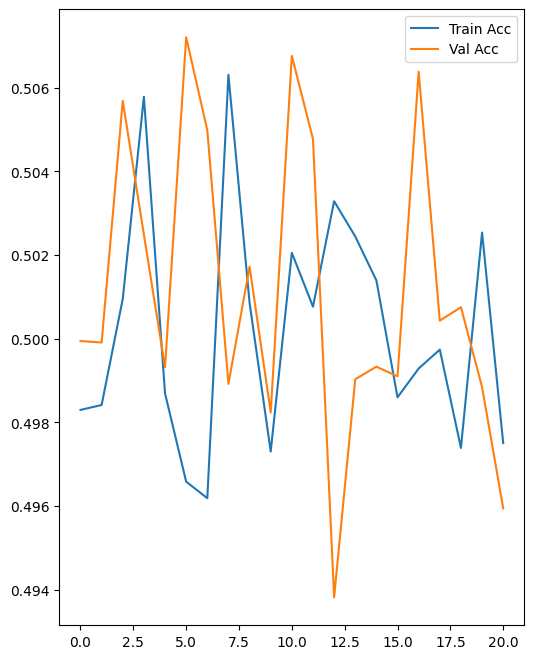

In [ ]:
# Import necessary libraries for plotting
import matplotlib.pyplot as plt

# Create a figure for the plot
plt.figure(figsize=(6, 8))

# Plot the training accuracy over epochs
plt.plot(range(history['epochs']), history['train_acc'], label='Train Acc')

# Plot the validation accuracy over epochs
plt.plot(range(history['epochs']), history['val_acc'], label='Val Acc')

# Add a legend to the plot to distinguish the two lines (train and validation accuracy)
plt.legend()

# Display the plot
plt.show()


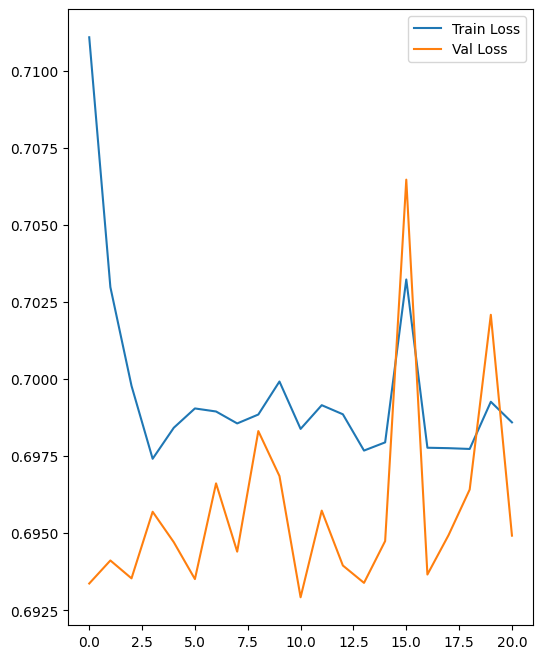

In [ ]:
# Import necessary libraries for plotting
import matplotlib.pyplot as plt

# Create a figure for the plot
plt.figure(figsize=(6, 8))

# Plot the training loss over epochs
plt.plot(range(history['epochs']), history['train_loss'], label='Train Loss')

# Plot the validation loss over epochs
plt.plot(range(history['epochs']), history['val_loss'], label='Val Loss')

# Add a legend to the plot to distinguish the two lines (train and validation loss)
plt.legend()

# Display the plot
plt.show()


In [ ]:
# Set the model in evaluation mode
model.eval()

# Initialize variables for metrics
test_loss = 0
test_acc = 0

# Lists to store all targets (ground truth) and predicted values
all_target = []
all_predicted = []

# Create a tqdm progress bar for iterating through the testloader
testloop = tqdm(testloader, leave=True, desc='Inference')

# Perform inference on the test data without computing gradients
with torch.no_grad():
    for feature, target in testloop:  # Loop through test data
        feature, target = feature.to(device), target.to(device)

        out = model(feature)  # Forward pass through the model

        # Calculate accuracy
        predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
        equals = predicted == target
        acc = torch.mean(equals.type(torch.FloatTensor))
        test_acc += acc.item()

        # Calculate loss
        loss = criterion(out.squeeze(), target.float())
        test_loss += loss.item()

        # Append the target (ground truth) and predicted values to the respective lists
        all_target.extend(target.cpu().numpy())
        all_predicted.extend(predicted.cpu().numpy())

    # Print the test accuracy and test loss
    print(f'Accuracy: {test_acc/len(testloader):.4f}, Loss: {test_loss/len(testloader):.4f}')


Inference: 100%|██████████| 59/59 [00:02<00:00, 24.05it/s]

Accuracy: 0.5016, Loss: 0.6946


In [ ]:
print(classification_report(all_predicted, all_target))

              precision    recall  f1-score   support

           0       0.04      0.50      0.08       313
           1       0.96      0.50      0.66      7187

    accuracy                           0.50      7500
   macro avg       0.50      0.50      0.37      7500
weighted avg       0.92      0.50      0.63      7500



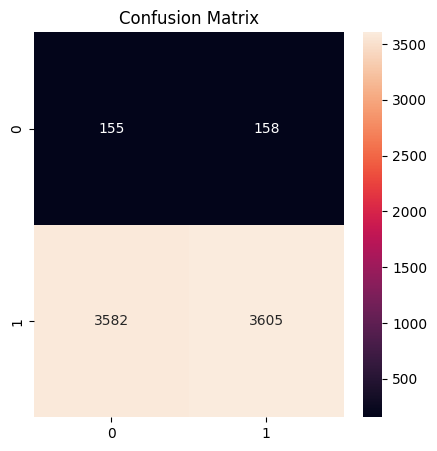

In [ ]:
cm = confusion_matrix(all_predicted, all_target)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Set the model in evaluation mode
model.eval()

# Initialize variables for metrics
test_loss = 0
test_acc = 0

# Lists to store all targets (ground truth) and predicted values
all_target = []
all_predicted = []

# Lists to store the original reviews
original_reviews = []

# Create a tqdm progress bar for iterating through the testloader
testloop = iter(testloader)

# Load a single batch from the test_loader
feature, target = next(testloop)

feature, target = feature.to(device), target.to(device)

# Extract the original reviews from the feature tensor
# This code assumes that the feature tensor contains the original text reviews
original_reviews = feature

with torch.no_grad():
    out = model(feature)  # Forward pass through the model

    # Calculate accuracy
    predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
    equals = predicted == target
    acc = torch.mean(equals.type(torch.FloatTensor))
    test_acc += acc.item()

    # Calculate loss
    loss = criterion(out.squeeze(), target.float())
    test_loss += loss.item()

    # Append the target (ground truth) and predicted values to the respective lists
    all_target.extend(target.cpu().numpy())
    all_predicted.extend(predicted.cpu().numpy())

# Print the test accuracy and test loss
print(f'Accuracy: {test_acc:.4f}, Loss: {test_loss:.4f}')

# Move the tensors to the CPU
original_reviews = original_reviews.cpu().numpy()
all_target = [int(target) for target in all_target]  # Convert to int


data = {
    'Original Review': list(original_reviews),
    'True Label': all_target,
    'Predicted Label': all_predicted
}

df = pd.DataFrame(data)
def map_review_to_keys(review, int2word):
    return [int2word[word] for word in review]

# Assuming your DataFrame is named df
df["Mapped Review"] = df["Original Review"].apply(lambda x: map_review_to_keys(x, int2word))

df





Accuracy: 0.5312, Loss: 0.6896


,Original Review,True Label,Predicted Label,Mapped Review
0,"[520, 45, 15, 2, 5260, 69924, 114752, 1912, 13...",0,1,"[Although, actor, good, ,, specially, Fritzi, ..."
1,"[47, 2985, 1189, 4876, 438, 3344, 332, 5196, 4...",1,0,"[A, noted, cinematic, phenomenon, late, eighty..."
2,"[117, 3, 48, 1, 47, 13746, 9921, 5, 432, 1, 67...",0,1,"[What, I, say, ., A, Kamal, Hassan, movie, hor..."
3,"[7, 1273, 19580, 448, 725, 1094, 257, 170, 324...",1,1,"[The, marriage, upscale, New, York, City, coup..."
4,"[2630, 2, 72, 33, 1, 1, 1110, 37616, 1291, 348...",1,1,"[Someone, ,, something, thing, ., ., leaving, ..."
...,...,...,...,...
123,"[3, 37, 223, 153, 121, 2, 353, 328, 2, 420, 4,...",1,1,"[I, think, short, TV, series, ,, absolutely, w..."
124,"[3, 1355, 2784, 1481, 690, 49, 494, 364, 306, ...",1,1,"[I, professional, musician, inspired, nearly, ..."
125,"[219, 398, 102, 3030, 13731, 75, 1, 3, 128, 36...",1,1,"[My, brother, got, hooked, Carlin, back, ., I,..."
126,"[1043, 3873, 2241, 6775, 791, 1076, 852, 1759,...",1,1,"[Best, Years, Our, Lives, perfectly, capture, ..."


#LSTM Model

In [ ]:
class SentimentModel(nn.Module):
    def __init__(self, vocab_size, output_size, hidden_size=128, embedding_size=400, n_layers=2, dropout=0.2):
        super(SentimentModel, self).__init__()

        # Embedding layer: Converts input tokens into vector representations
        self.embedding = nn.Embedding(vocab_size, embedding_size)

        # LSTM layer: A recurrent neural network layer with LSTM units
        self.lstm = nn.LSTM(embedding_size, hidden_size, n_layers, dropout=dropout, batch_first=True)

        # Dropout layer: Helps prevent overfitting by randomly "dropping out" units during training
        self.dropout = nn.Dropout(0.3)

        # Linear layer: A fully connected layer for the final output
        self.fc = nn.Linear(hidden_size, output_size)

        # Sigmoid layer: Used for binary classification to output probabilities
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Convert input feature to long data type (typically for IDs)
        x = x.long()

        # Map input to vector representations using the embedding layer
        x = self.embedding(x)

        # Pass the input forward through the LSTM layer
        o, _ =  self.lstm(x)

        # Get the output of the last time step of the sequence
        o = o[:, -1, :]

        # Apply dropout to the output
        o = self.dropout(o)

        # Pass the output through the fully connected linear layer
        o = self.fc(o)

        # Apply a sigmoid activation function to get probabilities for binary classification
        o = self.sigmoid(o)

        return o


In [ ]:
# define training device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
# Define model hyperparameters
vocab_size = len(word2int)  # The size of the vocabulary (number of unique words)
output_size = 1  # The output size, typically 1 for binary classification
embedding_size = 256  # The size of word embedding vectors
hidden_size = 512  # The number of units in the LSTM's hidden state
n_layers = 2  # The number of LSTM layers
dropout = 0.25  # Dropout probability for regularization

# Initialize the model with the specified hyperparameters
model = SentimentModel(vocab_size, output_size, hidden_size, embedding_size, n_layers, dropout)

# Print the model to inspect its architecture
print(model)


SentimentModel(
  (embedding): Embedding(121301, 256)
  (lstm): LSTM(256, 512, num_layers=2, batch_first=True, dropout=0.25)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [ ]:
# Training Configuration:
# Define various hyperparameters and settings for training the model.

# Learning Rate (lr)
lr = 0.001

# Criterion: Loss function used for training
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss is used because this is a binary classification problem.

# Optimizer: Adam optimizer is used to update model parameters during training.
optim = Adam(model.parameters(), lr=lr)

# Gradient Clipping (grad_clip)
grad_clip = 5  # Gradient clipping is applied to prevent exploding gradients during training.

# Number of Training Epochs (epochs)
epochs = 25

# Printing Frequency (print_every)
print_every = 1  # This determines how often training progress is printed.

# History Dictionary: Used to store training and validation metrics for later analysis.
history = {
    'train_loss': [],  # Training loss over epochs
    'train_acc': [],   # Training accuracy over epochs
    'val_loss': [],    # Validation loss over epochs
    'val_acc': [],     # Validation accuracy over epochs
    'epochs': epochs   # Total number of training epochs
}

# Early Stopping Limit (es_limit)
es_limit = 5  # Early stopping is applied if validation performance doesn't improve for 5 consecutive epochs.


In [ ]:
# train loop
model = model.to(device)  # Move the model to the specified device (e.g., CPU or GPU)

# Create a progress bar for epochs
epochloop = tqdm(range(epochs), position=0, desc='Training', leave=True)

# Initialize early stop trigger and minimum validation loss
es_trigger = 0
val_loss_min = torch.inf

# Loop through each training epoch
for e in epochloop:

    #################
    # Training Mode #
    #################

    model.train()  # Set the model in training mode

    train_loss = 0  # Initialize training loss
    train_acc = 0  # Initialize training accuracy

    for id, (feature, target) in enumerate(trainloader):  # Loop through training batches
        # Add epoch meta info to the progress bar
        epochloop.set_postfix_str(f'Training batch {id}/{len(trainloader)}')

        # Move input data and labels to the specified device
        feature, target = feature.to(device), target.to(device)

        # Reset the optimizer
        optim.zero_grad()

        # Forward pass
        out = model(feature)

        # Calculate accuracy
        predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
        equals = predicted == target
        acc = torch.mean(equals.type(torch.FloatTensor))
        train_acc += acc.item()

        # Calculate loss
        loss = criterion(out.squeeze(), target.float())
        train_loss += loss.item()
        loss.backward()

        # Clip gradients to prevent exploding gradients
        nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

        # Update the optimizer
        optim.step()

        # Free some memory by deleting variables
        del feature, target, predicted

    # Calculate and store training metrics for this epoch
    history['train_loss'].append(train_loss / len(trainloader))
    history['train_acc'].append(train_acc / len(trainloader))

    ####################
    # Validation Mode #
    ####################

    model.eval()  # Set the model in evaluation mode

    val_loss = 0  # Initialize validation loss
    val_acc = 0  # Initialize validation accuracy

    with torch.no_grad():
        for id, (feature, target) in enumerate(valloader):  # Loop through validation batches
            # Add epoch meta info to the progress bar
            epochloop.set_postfix_str(f'Validation batch {id}/{len(valloader)}')

            # Move input data and labels to the specified device
            feature, target = feature.to(device), target.to(device)

            # Forward pass
            out = model(feature)

            # Calculate accuracy
            predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
            equals = predicted == target
            acc = torch.mean(equals.type(torch.FloatTensor))
            val_acc += acc.item()

            # Calculate loss
            loss = criterion(out.squeeze(), target.float())
            val_loss += loss.item()

            # Free some memory by deleting variables
            del feature, target, predicted

        # Calculate and store validation metrics for this epoch
        history['val_loss'].append(val_loss / len(valloader))
        history['val_acc'].append(val_acc / len(valloader))

    # Reset the model mode to training for the next epoch
    model.train()

    # Add epoch meta info to the progress bar
    epochloop.set_postfix_str(f'Val Loss: {val_loss / len(valloader):.3f} | Val Acc: {val_acc / len(valloader):.3f}')

    # Print epoch results every 'print_every' epochs
    if (e + 1) % print_every == 0:
        epochloop.write(f'Epoch {e + 1}/{epochs} | Train Loss: {train_loss / len(trainloader):.3f} Train Acc: {train_acc / len(trainloader):.3f} | Val Loss: {val_loss / len(valloader):.3f} Val Acc: {val_acc / len(valloader):.3f}')
        epochloop.update()

    # Save the model if validation loss decreases
    if val_loss / len(valloader) <= val_loss_min:
        torch.save(model.state_dict(), './sentiment_lstm.pt')
        val_loss_min = val_loss / len(valloader)
        es_trigger = 0
    else:
        epochloop.write(f'[WARNING] Validation loss did not improve ({val_loss_min:.3f} --> {val_loss / len(valloader):.3f})')
        es_trigger += 1

    # Force early stop if 'es_limit' consecutive epochs have not shown improvement
    if es_trigger >= es_limit:
        epochloop.write(f'Early stopped at Epoch-{e + 1}')
        # Update the 'epochs' history to reflect the actual number of epochs completed
        history['epochs'] = e + 1
        break


Training:   4%|▍         | 1/25 [01:13<29:14, 73.11s/it, Val Loss: 0.693 | Val Acc: 0.502]

Epoch 1/25 | Train Loss: 0.694 Train Acc: 0.501 | Val Loss: 0.693 Val Acc: 0.502


Training:  12%|█▏        | 3/25 [02:27<18:23, 50.14s/it, Val Loss: 0.689 | Val Acc: 0.520]

Epoch 2/25 | Train Loss: 0.689 Train Acc: 0.512 | Val Loss: 0.689 Val Acc: 0.520


Training:  16%|█▌        | 4/25 [03:42<21:00, 60.01s/it, Val Loss: 0.567 | Val Acc: 0.713]

Epoch 3/25 | Train Loss: 0.634 Train Acc: 0.610 | Val Loss: 0.567 Val Acc: 0.713


Training:  24%|██▍       | 6/25 [04:57<16:06, 50.86s/it, Val Loss: 0.518 | Val Acc: 0.704]

Epoch 4/25 | Train Loss: 0.513 Train Acc: 0.714 | Val Loss: 0.518 Val Acc: 0.704


Training:  28%|██▊       | 7/25 [06:12<17:37, 58.76s/it, Val Loss: 0.517 | Val Acc: 0.695]

Epoch 5/25 | Train Loss: 0.442 Train Acc: 0.739 | Val Loss: 0.517 Val Acc: 0.695


Training:  32%|███▏      | 8/25 [07:27<18:07, 63.99s/it, Val Loss: 0.368 | Val Acc: 0.859]

Epoch 6/25 | Train Loss: 0.354 Train Acc: 0.806 | Val Loss: 0.368 Val Acc: 0.859


Training:  40%|████      | 10/25 [08:43<13:24, 53.63s/it, Training batch 0/274]            

Epoch 7/25 | Train Loss: 0.174 Train Acc: 0.941 | Val Loss: 0.377 Val Acc: 0.863
[WARNING] Validation loss did not improve (0.368 --> 0.377)


Training:  44%|████▍     | 11/25 [09:58<14:02, 60.15s/it, Training batch 0/274]            

Epoch 8/25 | Train Loss: 0.099 Train Acc: 0.971 | Val Loss: 0.442 Val Acc: 0.865
[WARNING] Validation loss did not improve (0.368 --> 0.442)


Training:  48%|████▊     | 12/25 [11:13<14:00, 64.65s/it, Training batch 0/274]            

Epoch 9/25 | Train Loss: 0.069 Train Acc: 0.982 | Val Loss: 0.482 Val Acc: 0.861
[WARNING] Validation loss did not improve (0.368 --> 0.482)


Training:  56%|█████▌    | 14/25 [12:27<12:24, 67.69s/it, Training batch 0/274]            

Epoch 10/25 | Train Loss: 0.049 Train Acc: 0.989 | Val Loss: 0.547 Val Acc: 0.857
[WARNING] Validation loss did not improve (0.368 --> 0.547)


Training:  40%|████      | 10/25 [13:42<20:33, 82.25s/it, Val Loss: 0.604 | Val Acc: 0.860]

Epoch 11/25 | Train Loss: 0.041 Train Acc: 0.991 | Val Loss: 0.604 Val Acc: 0.860
[WARNING] Validation loss did not improve (0.368 --> 0.604)
Early stopped at Epoch-11


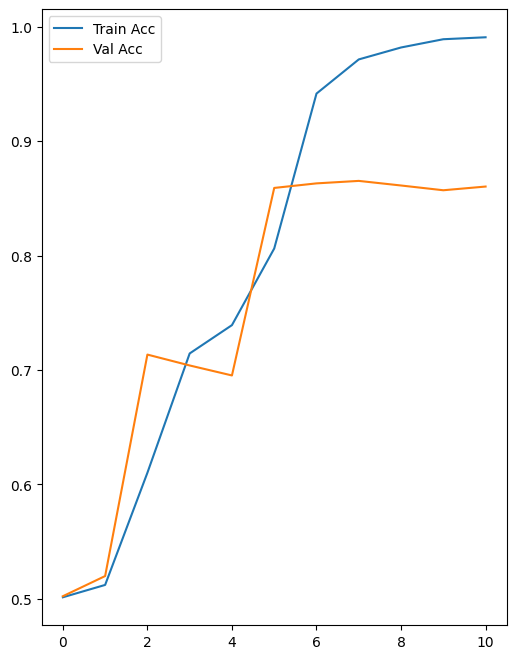

In [ ]:
# Import necessary libraries for plotting
import matplotlib.pyplot as plt

# Create a figure for the plot
plt.figure(figsize=(6, 8))

# Plot the training accuracy over epochs
plt.plot(range(history['epochs']), history['train_acc'], label='Train Acc')

# Plot the validation accuracy over epochs
plt.plot(range(history['epochs']), history['val_acc'], label='Val Acc')

# Add a legend to the plot to distinguish the two lines (train and validation accuracy)
plt.legend()

# Display the plot
plt.show()


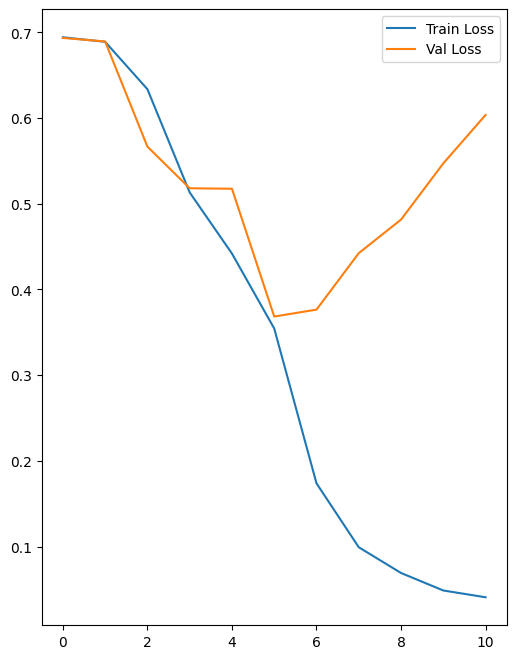

In [ ]:
# Import necessary libraries for plotting
import matplotlib.pyplot as plt

# Create a figure for the plot
plt.figure(figsize=(6, 8))

# Plot the training loss over epochs
plt.plot(range(history['epochs']), history['train_loss'], label='Train Loss')

# Plot the validation loss over epochs
plt.plot(range(history['epochs']), history['val_loss'], label='Val Loss')

# Add a legend to the plot to distinguish the two lines (train and validation loss)
plt.legend()

# Display the plot
plt.show()


In [ ]:
# Set the model in evaluation mode
model.eval()

# Initialize variables for metrics
test_loss = 0
test_acc = 0

# Lists to store all targets (ground truth) and predicted values
all_target = []
all_predicted = []

# Create a tqdm progress bar for iterating through the testloader
testloop = tqdm(testloader, leave=True, desc='Inference')

# Perform inference on the test data without computing gradients
with torch.no_grad():
    for feature, target in testloop:  # Loop through test data
        feature, target = feature.to(device), target.to(device)

        out = model(feature)  # Forward pass through the model

        # Calculate accuracy
        predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
        equals = predicted == target
        acc = torch.mean(equals.type(torch.FloatTensor))
        test_acc += acc.item()

        # Calculate loss
        loss = criterion(out.squeeze(), target.float())
        test_loss += loss.item()

        # Append the target (ground truth) and predicted values to the respective lists
        all_target.extend(target.cpu().numpy())
        all_predicted.extend(predicted.cpu().numpy())

    # Print the test accuracy and test loss
    print(f'Accuracy: {test_acc/len(testloader):.4f}, Loss: {test_loss/len(testloader):.4f}')


Inference: 100%|██████████| 59/59 [00:05<00:00, 11.73it/s]

Accuracy: 0.8623, Loss: 0.5876


In [ ]:
print(classification_report(all_predicted, all_target))

              precision    recall  f1-score   support

           0       0.88      0.85      0.86      3849
           1       0.85      0.87      0.86      3651

    accuracy                           0.86      7500
   macro avg       0.86      0.86      0.86      7500
weighted avg       0.86      0.86      0.86      7500



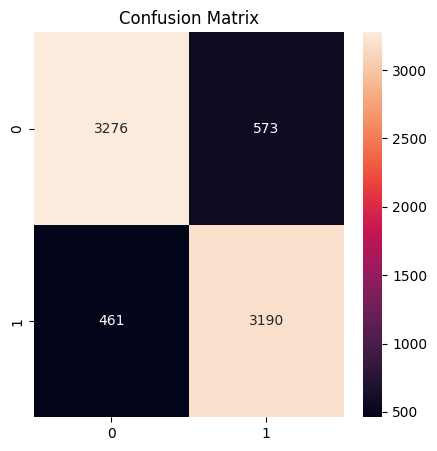

In [ ]:
cm = confusion_matrix(all_predicted, all_target)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Set the model in evaluation mode
model.eval()

# Initialize variables for metrics
test_loss = 0
test_acc = 0

# Lists to store all targets (ground truth) and predicted values
all_target = []
all_predicted = []

# Lists to store the original reviews
original_reviews = []

# Create a tqdm progress bar for iterating through the testloader
testloop = iter(testloader)

# Load a single batch from the test_loader
feature, target = next(testloop)

feature, target = feature.to(device), target.to(device)

# Extract the original reviews from the feature tensor
# This code assumes that the feature tensor contains the original text reviews
original_reviews = feature

with torch.no_grad():
    out = model(feature)  # Forward pass through the model

    # Calculate accuracy
    predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
    equals = predicted == target
    acc = torch.mean(equals.type(torch.FloatTensor))
    test_acc += acc.item()

    # Calculate loss
    loss = criterion(out.squeeze(), target.float())
    test_loss += loss.item()

    # Append the target (ground truth) and predicted values to the respective lists
    all_target.extend(target.cpu().numpy())
    all_predicted.extend(predicted.cpu().numpy())

# Print the test accuracy and test loss
print(f'Accuracy: {test_acc:.4f}, Loss: {test_loss:.4f}')

# Move the tensors to the CPU
original_reviews = original_reviews.cpu().numpy()
all_target = [int(target) for target in all_target]  # Convert to int


data = {
    'Original Review': list(original_reviews),
    'True Label': all_target,
    'Predicted Label': all_predicted
}

df = pd.DataFrame(data)
def map_review_to_keys(review, int2word):
    return [int2word[word] for word in review]

# Assuming your DataFrame is named df
df["Mapped Review"] = df["Original Review"].apply(lambda x: map_review_to_keys(x, int2word))

df





Accuracy: 0.8594, Loss: 0.4927


,Original Review,True Label,Predicted Label,Mapped Review
0,"[3, 4029, 5, 114, 6771, 225, 733, 32681, 5034,...",1,1,"[I, witnessed, movie, right, fodder, second, r..."
1,"[3, 4809, 133, 27, 200, 19361, 1, 6215, 1, 64,...",1,1,"[I, gather, least, people, watched, Sept, ., T..."
2,"[3, 1222, 834, 299, 32, 18721, 1123, 242, 1, 3...",0,0,"[I, suppose, inside, joke, made, Munchies, cul..."
3,"[218, 31, 2, 43, 1, 55824, 9104, 12, 2067, 342...",0,0,"[All, show, ,, plot, ., Kuszko, spelling, ?, d..."
4,"[3, 200, 5, 34, 13, 6820, 154, 162, 761, 1, 11...",1,0,"[I, watched, movie, first, time, finishing, bo..."
...,...,...,...,...
123,"[7, 783, 1844, 100, 2942, 5040, 3343, 150, 6, ...",1,1,"[The, location, shop, around, corner, precisel..."
124,"[3407, 1510, 2, 448, 725, 241, 2011, 2058, 2, ...",0,0,"[Glenn, Ford, ,, New, York, boy, saving, cash,..."
125,"[14, 2920, 6, 1, 11, 70, 99, 2, 70, 327, 2, 70...",1,0,"[This, exceptional, film, ., It, part, comedy,..."
126,"[14, 60, 5, 3, 61, 44, 1, 3, 44, 5, 4892, 588,...",1,1,"[This, best, movie, I, ever, seen, ., I, seen,..."


#GRU Model

In [ ]:
import torch
import torch.nn as nn

class SentimentGRUModel(nn.Module):
    def __init__(self, vocab_size, output_size, hidden_size=128, embedding_size=400, n_layers=2, dropout=0.2):
        super(SentimentGRUModel, self).__init__()

        # Embedding layer: Converts input tokens into vector representations
        self.embedding = nn.Embedding(vocab_size, embedding_size)

        # GRU layer: A recurrent neural network layer with GRU units
        self.gru = nn.GRU(embedding_size, hidden_size, num_layers=n_layers, dropout=dropout, batch_first=True)

        # Dropout layer: Helps prevent overfitting by randomly "dropping out" units during training
        self.dropout = nn.Dropout(0.3)

        # Linear layer: A fully connected layer for the final output
        self.fc = nn.Linear(hidden_size, output_size)

        # Sigmoid layer: Used for binary classification to output probabilities
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Convert input feature to long data type (typically for IDs)
        x = x.long()

        # Map input to vector representations using the embedding layer
        x = self.embedding(x)

        # Pass the input forward through the GRU layer
        o, _ = self.gru(x)

        # Get the output of the last time step of the sequence
        o = o[:, -1, :]

        # Apply dropout to the output
        o = self.dropout(o)

        # Pass the output through the fully connected linear layer
        o = self.fc(o)

        # Apply a sigmoid activation function to get probabilities for binary classification
        o = self.sigmoid(o)

        return o


In [ ]:
# define training device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
# Define model hyperparameters
vocab_size = len(word2int)  # The size of the vocabulary (number of unique words)
output_size = 1  # The output size, typically 1 for binary classification
embedding_size = 256  # The size of word embedding vectors
hidden_size = 512  # The number of units in the LSTM's hidden state
n_layers = 2  # The number of LSTM layers
dropout = 0.25  # Dropout probability for regularization

# Initialize the model with the specified hyperparameters
model = SentimentGRUModel(vocab_size, output_size, hidden_size, embedding_size, n_layers, dropout)

# Print the model to inspect its architecture
print(model)


SentimentGRUModel(
  (embedding): Embedding(121301, 256)
  (gru): GRU(256, 512, num_layers=2, batch_first=True, dropout=0.25)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [ ]:
# Training Configuration:
# Define various hyperparameters and settings for training the model.

# Learning Rate (lr)
lr = 0.001

# Criterion: Loss function used for training
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss is used because this is a binary classification problem.

# Optimizer: Adam optimizer is used to update model parameters during training.
optim = Adam(model.parameters(), lr=lr)

# Gradient Clipping (grad_clip)
grad_clip = 5  # Gradient clipping is applied to prevent exploding gradients during training.

# Number of Training Epochs (epochs)
epochs = 25

# Printing Frequency (print_every)
print_every = 1  # This determines how often training progress is printed.

# History Dictionary: Used to store training and validation metrics for later analysis.
history = {
    'train_loss': [],  # Training loss over epochs
    'train_acc': [],   # Training accuracy over epochs
    'val_loss': [],    # Validation loss over epochs
    'val_acc': [],     # Validation accuracy over epochs
    'epochs': epochs   # Total number of training epochs
}

# Early Stopping Limit (es_limit)
es_limit = 5  # Early stopping is applied if validation performance doesn't improve for 5 consecutive epochs.


In [ ]:
# train loop
model = model.to(device)  # Move the model to the specified device (e.g., CPU or GPU)

# Create a progress bar for epochs
epochloop = tqdm(range(epochs), position=0, desc='Training', leave=True)

# Initialize early stop trigger and minimum validation loss
es_trigger = 0
val_loss_min = torch.inf

# Loop through each training epoch
for e in epochloop:

    #################
    # Training Mode #
    #################

    model.train()  # Set the model in training mode

    train_loss = 0  # Initialize training loss
    train_acc = 0  # Initialize training accuracy

    for id, (feature, target) in enumerate(trainloader):  # Loop through training batches
        # Add epoch meta info to the progress bar
        epochloop.set_postfix_str(f'Training batch {id}/{len(trainloader)}')

        # Move input data and labels to the specified device
        feature, target = feature.to(device), target.to(device)

        # Reset the optimizer
        optim.zero_grad()

        # Forward pass
        out = model(feature)

        # Calculate accuracy
        predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
        equals = predicted == target
        acc = torch.mean(equals.type(torch.FloatTensor))
        train_acc += acc.item()

        # Calculate loss
        loss = criterion(out.squeeze(), target.float())
        train_loss += loss.item()
        loss.backward()

        # Clip gradients to prevent exploding gradients
        nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

        # Update the optimizer
        optim.step()

        # Free some memory by deleting variables
        del feature, target, predicted

    # Calculate and store training metrics for this epoch
    history['train_loss'].append(train_loss / len(trainloader))
    history['train_acc'].append(train_acc / len(trainloader))

    ####################
    # Validation Mode #
    ####################

    model.eval()  # Set the model in evaluation mode

    val_loss = 0  # Initialize validation loss
    val_acc = 0  # Initialize validation accuracy

    with torch.no_grad():
        for id, (feature, target) in enumerate(valloader):  # Loop through validation batches
            # Add epoch meta info to the progress bar
            epochloop.set_postfix_str(f'Validation batch {id}/{len(valloader)}')

            # Move input data and labels to the specified device
            feature, target = feature.to(device), target.to(device)

            # Forward pass
            out = model(feature)

            # Calculate accuracy
            predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
            equals = predicted == target
            acc = torch.mean(equals.type(torch.FloatTensor))
            val_acc += acc.item()

            # Calculate loss
            loss = criterion(out.squeeze(), target.float())
            val_loss += loss.item()

            # Free some memory by deleting variables
            del feature, target, predicted

        # Calculate and store validation metrics for this epoch
        history['val_loss'].append(val_loss / len(valloader))
        history['val_acc'].append(val_acc / len(valloader))

    # Reset the model mode to training for the next epoch
    model.train()

    # Add epoch meta info to the progress bar
    epochloop.set_postfix_str(f'Val Loss: {val_loss / len(valloader):.3f} | Val Acc: {val_acc / len(valloader):.3f}')

    # Print epoch results every 'print_every' epochs
    if (e + 1) % print_every == 0:
        epochloop.write(f'Epoch {e + 1}/{epochs} | Train Loss: {train_loss / len(trainloader):.3f} Train Acc: {train_acc / len(trainloader):.3f} | Val Loss: {val_loss / len(valloader):.3f} Val Acc: {val_acc / len(valloader):.3f}')
        epochloop.update()

    # Save the model if validation loss decreases
    if val_loss / len(valloader) <= val_loss_min:
        torch.save(model.state_dict(), './sentiment_lstm.pt')
        val_loss_min = val_loss / len(valloader)
        es_trigger = 0
    else:
        epochloop.write(f'[WARNING] Validation loss did not improve ({val_loss_min:.3f} --> {val_loss / len(valloader):.3f})')
        es_trigger += 1

    # Force early stop if 'es_limit' consecutive epochs have not shown improvement
    if es_trigger >= es_limit:
        epochloop.write(f'Early stopped at Epoch-{e + 1}')
        # Update the 'epochs' history to reflect the actual number of epochs completed
        history['epochs'] = e + 1
        break


Training:   4%|▍         | 1/25 [01:01<24:28, 61.18s/it, Val Loss: 0.480 | Val Acc: 0.779]

Epoch 1/25 | Train Loss: 0.665 Train Acc: 0.568 | Val Loss: 0.480 Val Acc: 0.779


Training:  12%|█▏        | 3/25 [02:03<15:22, 41.95s/it, Val Loss: 0.300 | Val Acc: 0.868]

Epoch 2/25 | Train Loss: 0.343 Train Acc: 0.854 | Val Loss: 0.300 Val Acc: 0.868


Training:  16%|█▌        | 4/25 [03:05<17:27, 49.90s/it, Val Loss: 0.298 | Val Acc: 0.883]

Epoch 3/25 | Train Loss: 0.194 Train Acc: 0.927 | Val Loss: 0.298 Val Acc: 0.883


Training:  24%|██▍       | 6/25 [04:07<13:19, 42.10s/it, Training batch 0/274]            

Epoch 4/25 | Train Loss: 0.096 Train Acc: 0.966 | Val Loss: 0.406 Val Acc: 0.875
[WARNING] Validation loss did not improve (0.298 --> 0.406)


Training:  28%|██▊       | 7/25 [05:08<14:32, 48.45s/it, Training batch 0/274]            

Epoch 5/25 | Train Loss: 0.042 Train Acc: 0.987 | Val Loss: 0.425 Val Acc: 0.874
[WARNING] Validation loss did not improve (0.298 --> 0.425)


Training:  36%|███▌      | 9/25 [06:10<14:01, 52.62s/it, Training batch 0/274]            

Epoch 6/25 | Train Loss: 0.027 Train Acc: 0.992 | Val Loss: 0.510 Val Acc: 0.869
[WARNING] Validation loss did not improve (0.298 --> 0.510)


Training:  40%|████      | 10/25 [07:12<10:33, 42.22s/it, Training batch 0/274]            

Epoch 7/25 | Train Loss: 0.017 Train Acc: 0.995 | Val Loss: 0.591 Val Acc: 0.872
[WARNING] Validation loss did not improve (0.298 --> 0.591)


Training:  28%|██▊       | 7/25 [08:13<21:08, 70.49s/it, Val Loss: 0.624 | Val Acc: 0.865] 

Epoch 8/25 | Train Loss: 0.012 Train Acc: 0.996 | Val Loss: 0.624 Val Acc: 0.865
[WARNING] Validation loss did not improve (0.298 --> 0.624)
Early stopped at Epoch-8


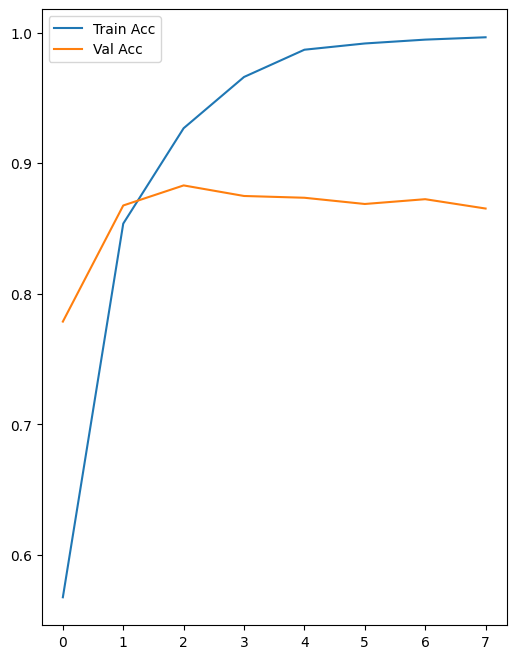

In [ ]:
# Import necessary libraries for plotting
import matplotlib.pyplot as plt

# Create a figure for the plot
plt.figure(figsize=(6, 8))

# Plot the training accuracy over epochs
plt.plot(range(history['epochs']), history['train_acc'], label='Train Acc')

# Plot the validation accuracy over epochs
plt.plot(range(history['epochs']), history['val_acc'], label='Val Acc')

# Add a legend to the plot to distinguish the two lines (train and validation accuracy)
plt.legend()

# Display the plot
plt.show()


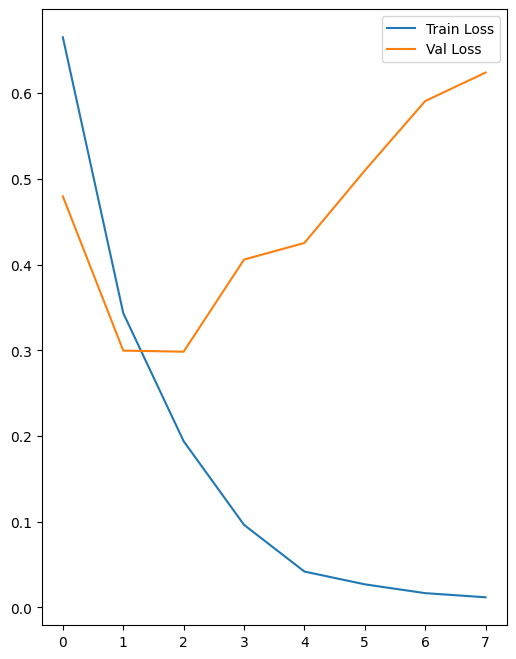

In [ ]:
# Import necessary libraries for plotting
import matplotlib.pyplot as plt

# Create a figure for the plot
plt.figure(figsize=(6, 8))

# Plot the training loss over epochs
plt.plot(range(history['epochs']), history['train_loss'], label='Train Loss')

# Plot the validation loss over epochs
plt.plot(range(history['epochs']), history['val_loss'], label='Val Loss')

# Add a legend to the plot to distinguish the two lines (train and validation loss)
plt.legend()

# Display the plot
plt.show()


In [ ]:
# Set the model in evaluation mode
model.eval()

# Initialize variables for metrics
test_loss = 0
test_acc = 0

# Lists to store all targets (ground truth) and predicted values
all_target = []
all_predicted = []

# Create a tqdm progress bar for iterating through the testloader
testloop = tqdm(testloader, leave=True, desc='Inference')

# Perform inference on the test data without computing gradients
with torch.no_grad():
    for feature, target in testloop:  # Loop through test data
        feature, target = feature.to(device), target.to(device)

        out = model(feature)  # Forward pass through the model

        # Calculate accuracy
        predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
        equals = predicted == target
        acc = torch.mean(equals.type(torch.FloatTensor))
        test_acc += acc.item()

        # Calculate loss
        loss = criterion(out.squeeze(), target.float())
        test_loss += loss.item()

        # Append the target (ground truth) and predicted values to the respective lists
        all_target.extend(target.cpu().numpy())
        all_predicted.extend(predicted.cpu().numpy())

    # Print the test accuracy and test loss
    print(f'Accuracy: {test_acc/len(testloader):.4f}, Loss: {test_loss/len(testloader):.4f}')


Inference: 100%|██████████| 59/59 [00:03<00:00, 14.96it/s]

Accuracy: 0.8745, Loss: 0.5982


In [ ]:
print(classification_report(all_predicted, all_target))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87      3485
           1       0.91      0.85      0.88      4015

    accuracy                           0.87      7500
   macro avg       0.87      0.88      0.87      7500
weighted avg       0.88      0.87      0.87      7500



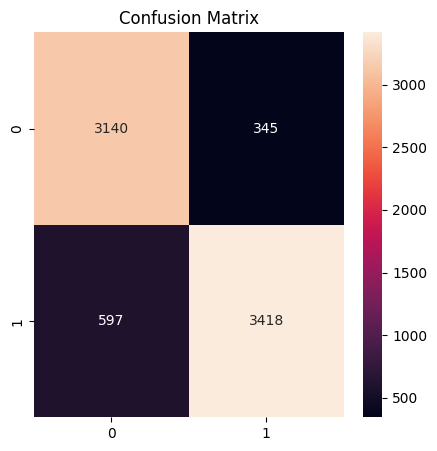

In [ ]:
cm = confusion_matrix(all_predicted, all_target)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Set the model in evaluation mode
model.eval()

# Initialize variables for metrics
test_loss = 0
test_acc = 0

# Lists to store all targets (ground truth) and predicted values
all_target = []
all_predicted = []

# Lists to store the original reviews
original_reviews = []

# Create a tqdm progress bar for iterating through the testloader
testloop = iter(testloader)

# Load a single batch from the test_loader
feature, target = next(testloop)

feature, target = feature.to(device), target.to(device)

# Extract the original reviews from the feature tensor
# This code assumes that the feature tensor contains the original text reviews
original_reviews = feature

with torch.no_grad():
    out = model(feature)  # Forward pass through the model

    # Calculate accuracy
    predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
    equals = predicted == target
    acc = torch.mean(equals.type(torch.FloatTensor))
    test_acc += acc.item()

    # Calculate loss
    loss = criterion(out.squeeze(), target.float())
    test_loss += loss.item()

    # Append the target (ground truth) and predicted values to the respective lists
    all_target.extend(target.cpu().numpy())
    all_predicted.extend(predicted.cpu().numpy())

# Print the test accuracy and test loss
print(f'Accuracy: {test_acc:.4f}, Loss: {test_loss:.4f}')

# Move the tensors to the CPU
original_reviews = original_reviews.cpu().numpy()
all_target = [int(target) for target in all_target]  # Convert to int


data = {
    'Original Review': list(original_reviews),
    'True Label': all_target,
    'Predicted Label': all_predicted
}

df = pd.DataFrame(data)
def map_review_to_keys(review, int2word):
    return [int2word[word] for word in review]

# Assuming your DataFrame is named df
df["Mapped Review"] = df["Original Review"].apply(lambda x: map_review_to_keys(x, int2word))

df





Accuracy: 0.8672, Loss: 0.6703


,Original Review,True Label,Predicted Label,Mapped Review
0,"[789, 1, 19334, 16515, 32, 481, 228, 6, 2, 105...",0,0,"[T, ., Rama, Rao, made, extremely, beautiful, ..."
1,"[3, 130, 6, 4037, 1091, 2214, 390, 33303, 1, 3...",1,0,"[I, saw, film, International, Film, Festival, ..."
2,"[3, 48, 294, 5, 2, 2783, 96, 21, 5, 3024, 2, 3...",0,0,"[I, say, awful, movie, ,, mere, fact, see, mov..."
3,"[1, 1, 1, 15, 125, 1, 1053, 690, 6813, 4601, 4...",1,0,"[., ., ., good, original, ., Very, nearly, ach..."
4,"[7, 96, 205, 88, 851, 201, 28, 129, 2, 622, 1,...",0,0,"[The, fact, someone, actually, spent, money, b..."
...,...,...,...,...
123,"[11, 506, 1722, 1, 3, 6111, 17835, 245, 51, 11...",0,0,"[It, complete, nonsense, ., I, studied, Nazism..."
124,"[1667, 7077, 172, 1942, 2, 990, 33, 172, 1, 41...",1,1,"[Arthur, Bach, need, grow, ,, unfortunately, t..."
125,"[23417, 3679, 135, 599, 392, 2, 447, 9474, 105...",1,1,"[Dekalog, Five, interesting, viewing, experien..."
126,"[3, 367, 5, 2, 10, 234, 206, 2, 113, 1283, 109...",1,0,"[I, loved, movie, ,, like, everyone, said, ,, ..."
